# Homework6: Evaluation of implicit models + discrete VAE.

Ульяна Быкова

Версия 2 - обнаружила ошибку в коде в _VectorQuantizer.get_quantized()_

## Libraries

In [1]:
# !pip install --upgrade --no-cache-dir gdown

# REPO_NAME = "2022-2023-DGM-AIMasters-course"
# !if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
# !git clone https://github.com/r-isachenko/{REPO_NAME}.git
# !cd {REPO_NAME}
# !pip install ./{REPO_NAME}/homeworks/
# !mv ./{REPO_NAME}/homeworks/stylegan.py ./stylegan.py
# !mv ./{REPO_NAME}/homeworks/inception.py ./inception.py
# !rm -Rf {REPO_NAME}

In [2]:
from dgm_utils import train_model, show_samples, plot_training_curves
from dgm_utils import visualize_images, load_pickle

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import entropy
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn import functional as F
from inception import InceptionV3

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

print('cuda is available:', USE_CUDA)

cuda is available: True


## Task 2: Inception Score and FID (4pt)

Here our goal is to understand how to evaluate likelihood-free models using [Inception Score](https://arxiv.org/pdf/1606.03498.pdf) and [Frechet Inception Distance](https://arxiv.org/pdf/1706.08500.pdf).

In [ ]:
# do not change this function
def plot_losses(losses, title):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    
    
# this is a helper function that we will use further
def resize_tensor(x, image_size):
    return F.interpolate(x, size=(image_size, image_size), mode='bilinear', align_corners=False)

Your task is to implement the *Inception score* and *FID* score and estimate the quality of two trained *StyleGAN* models we have discussed on Seminar 11 and Seminar 12: 

1. `stylegan_wgangp` is a *StyleGAN* model trained with *WGAN-GP* loss on `CIFAR10` dataset ([ckpt_link](https://drive.google.com/file/d/1bTDbmleLXowuGcahsoSBeihSVbGgW52X/view?usp=sharing))

2. `stylegan_r1` is a *StyleGAN* model trained with standard gan loss with $R_1$ regularization on `CIFAR10` dataset ([ckpt_link](https://drive.google.com/file/d/1PNeESbetxazQkBJbBnoizyWgGKJwfpW5/view?usp=sharing))

In [ ]:
# # loading models checkpoints
# !gdown 1bTDbmleLXowuGcahsoSBeihSVbGgW52X
# !gdown 1PNeESbetxazQkBJbBnoizyWgGKJwfpW5

In [ ]:
from stylegan import MicroStyleGANGenerator
from copy import deepcopy

sg_wgangp_name = 'stylegan_wgangp_loss_FINAL.pth'
sg_gan_r1_name = 'stylegan_gan_r1_loss_FINAL.pth'


stylegan_wgangp = MicroStyleGANGenerator(
    z_dim=128, 
    map_hidden_dim=256,
    w_dim=64,
    in_chan=64,
    out_chan=3, 
    kernel_size=3, 
    hidden_chan=32
)

stylegan_r1 = deepcopy(stylegan_wgangp)

stylegan_wgangp.load_state_dict(
    torch.load('./{}'.format(sg_wgangp_name), map_location='cpu')['generator'])

stylegan_r1.load_state_dict(
    torch.load('./{}'.format(sg_gan_r1_name), map_location='cpu')['generator'])

Let's look at model samples from `stylegan_r1`.

In [ ]:
batch = stylegan_r1.sample(100).detach().cpu().numpy()
show_samples(batch, 'CIFAR10 samples, shape = ({0}, {0})'.format(32), nrow=10)

Let's look at model samples from `stylegan_wgangp`.

In [ ]:
batch = stylegan_wgangp.sample(100).detach().cpu().numpy()
show_samples(batch, 'CIFAR10 samples, shape = ({0}, {0})'.format(32), nrow=10)

###  Inception Score

The formula for Inception Score is
$$
    \text{IS} = \exp \bigl( \mathbb{E}_{\mathbf{x}} KL(p(y | \mathbf{x}) || p(y)) \bigr),
$$

where 
* $p(y | \mathbf{x})$ is a pretrained classification model with labels $y$ (we will use [Inception V3 model](https://pytorch.org/vision/main/generated/torchvision.models.inception_v3.html));
* $p(y) = \int p(y | \mathbf{x}) p(\mathbf{x}) d \mathbf{x}$ is a marginal distribution on labels.

In order to calculate the **Inception** score we will use `InceptionV3` last layer activations (those before computing `Softmax`). The dimensionality of these activations is $1008$.

Let initialize our classification model.

In [ ]:
DIMS = 1008
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[DIMS]
inception_model_act5 = InceptionV3([block_idx])
inception_model_act5 = inception_model_act5.to(DEVICE)
inception_model_act5.eval()

We need to get class probabilities from our classification model.

In [ ]:
def get_inception_probs(x, model):
    # ====
    # apply model and get probs (apply softmax)
    probs = model.forward(x).softmax(dim=-1)
    # ====
    return probs.data.cpu().numpy()


def test_get_inception_probs():
    x = torch.zeros(size=(1, 3, 10, 10))
    x = x.to(DEVICE)
    probs = get_inception_probs(x, inception_model_act5)
    true_probs = np.array([
        0.00012616384, 
        0.00031305864,
        0.00019984621,
        0.00024997862,
        0.00005619833,
        0.00010180601,
        0.00002303111,
        0.0001946776,
        0.0015921608,
        0.000064336535,
    ])
    assert np.allclose(probs[0, :10], true_probs)


test_get_inception_probs()

In [ ]:
# this is a helper function that generates samples from the StyleGAN generator
def generate_fake_images_stylegan(sg_generator, n_samples, batch_size):
    fake_images = []
    for i in range(n_samples // batch_size):
        fake_samples = sg_generator.sample(batch_size).cpu().detach().numpy()
        fake_images.extend(fake_samples)

    fake_samples = sg_generator.sample(n_samples % batch_size).cpu().detach().numpy()
    fake_images.extend(fake_samples)
    return np.array(fake_images)

It is the main function for getting Inception Score.

In [ ]:
def get_inception_score(generator, inception_model, n_samples, batch_size=32, splits=10):
    generator = generator.to(DEVICE)
    inception_model = inception_model.to(DEVICE)

    generator.eval()
    inception_model.eval()

    fake_images = generate_fake_images_stylegan(generator, n_samples, batch_size)
    loader = torch.utils.data.DataLoader(fake_images, batch_size=batch_size)

    # ====
    # get probs of size [n_samples x 1000] for the fake_samples
    probs = []
    
    
    for batch in loader:
        batch = batch.to(DEVICE)
        batch_probs = get_inception_probs(batch.float(), inception_model)
        probs.append(torch.tensor(batch_probs))
        
    probs = torch.cat(probs, dim=0)
    
    # ====
    split_scores = []

    for k in range(splits):
        part = probs[k * (n_samples // splits): (k + 1) * (n_samples // splits), :]
        # ====
        # 1) calculate p_y mean value of the current part
        # 2) calculate KL (use could you entropy function from scipy)
        # 3) exponentiate it
        
        # https://github.com/vslvskyy/gan-metrics-in-pytorch/blob/2acfdfce927418f1e7dc91b18eac2f05a18d05f9/gan_metrics/inception_score.py#L52
        
        kl = part * (torch.log(part) - torch.log(torch.unsqueeze(torch.mean(part, 0), 0)))
        kl = torch.mean(torch.sum(kl, 1))
        split_score = torch.exp(kl)

        # ====
        split_scores.append(split_score)

    return np.mean(split_scores)

In [ ]:
N_SAMPLES = 1000
BATCH_SIZE = 16
SPLITS = 5

reset_seed()

IS_stylegan_r1 = get_inception_score(
    generator=stylegan_r1,
    inception_model=inception_model_act5,
    n_samples=N_SAMPLES,
    batch_size=BATCH_SIZE,
    splits=SPLITS
)

reset_seed()

IS_stylegan_wgangp = get_inception_score(
    generator=stylegan_wgangp,
    inception_model=inception_model_act5,
    n_samples=N_SAMPLES,
    batch_size=BATCH_SIZE,
    splits=SPLITS
)

In [ ]:
assert np.allclose(IS_stylegan_r1, 6.566, atol=0.1)
assert np.allclose(IS_stylegan_wgangp, 6.63, atol=0.1)

###  Frechet Inception Distance

Now we will implement Frechet Inception Distance:

$$
	\text{FID} (\pi, p) = \| \mathbf{m}_{\pi} - \mathbf{m}_{p}\|_2^2 + \text{Tr} \left( \boldsymbol{\Sigma}_{\pi} + \boldsymbol{\Sigma}_p - 2 \sqrt{\boldsymbol{\Sigma}_{\pi} \boldsymbol{\Sigma}_p} \right)
$$

* Representations are the outputs of the intermediate layer from the pretrained classification model (we will use the activations of the last by one layer of `InceptionV3` (which have dimensionality $(2048, 1, 1)$), that's why the last two dimensions should be dropped before FID statistics calculation).
* $\mathbf{m}_{\pi}$, $\boldsymbol{\Sigma}_{\pi} $ are the mean vector and the covariance matrix of feature representations for samples from $\pi(\mathbf{x})$
* $\mathbf{m}_{p}$, $\boldsymbol{\Sigma}_p$ are the mean vector and the covariance matrix of feature representations for samples from $p(\mathbf{x} | \boldsymbol{\theta})$.

Let initialize our classification model which outputs last by one activations:

In [ ]:
DIMS = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[DIMS]
inception_model_act4 = InceptionV3([block_idx])
if USE_CUDA:
    inception_model_act4 = inception_model_act4.cuda()
inception_model_act4.eval()

Here we need samples from the ground truth distribution $\pi(\mathbf{x})$ (`CIFAR10` images).

In [ ]:
# !gdown 1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj

In [ ]:
train_data, test_data = load_pickle('./cifar10.pkl')
#visualize_images(train_data, 'CIFAR10 samples')

Let implement function to take square root of matrix (we need it for the formula above).

In [ ]:
# this is a helper function, do not change
def get_matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    if not np.isfinite(y).all():
        print('bad!')
    return torch.Tensor(y.real, device=x.device)

Not let implement the function to calculate the distance (it is just the formula above).

In [ ]:
def get_distance(mu_x, mu_y, sigma_x, sigma_y):
    # ====
    sigma_sqrt = 2 * get_matrix_sqrt(sigma_x.cpu() @ sigma_y.cpu())
    sigma_sqrt = sigma_sqrt.to(mu_x.device)
    trace = torch.tensor(np.trace((sigma_x + sigma_y - sigma_sqrt).cpu())).to(sigma_x.device)
    norm = (mu_x - mu_y) @ (mu_x - mu_y)
    return norm + trace
    # ====


def test_get_distance():
    mu_x = torch.ones(3)
    mu_y = torch.ones(3) * 10
    sigma_x = torch.eye(3) * 5
    sigma_y = torch.eye(3) * 3
    dist = get_distance(mu_x, mu_y, sigma_x, sigma_y)
    assert np.isclose(dist, 243.7621)


test_get_distance()

Let implement the function which calculate intermediate representations for real and fake samples.

In [ ]:
def get_features(generator, inception_model, loader, n_samples, batch_size):
    generator = generator.to(DEVICE)
    inception_model.to(DEVICE)

    generator.eval()
    inception_model.eval()

    fake_features_list = []
    real_features_list = []
    cur_samples = 0

    with torch.no_grad():
        for real_samples in loader: 
            # real_samples = resize_tensor(real_samples, image_size) 
            real_samples = real_samples.to(DEVICE)
            # ====
            # get features of real samples
            # drop the w and h dimensions of the obtained features
            real_features = inception_model.forward(real_samples)
            real_features = real_features.squeeze()
            # ====
            # ====
            # get features of fake samples
            # drop the w and h dimensions of the the obtained features
            fake_samples = generator.sample(len(real_samples))
            fake_features = inception_model.forward(fake_samples)
            
            fake_features = fake_features.squeeze()
            # ====
            fake_features_list.append(fake_features)
            real_features_list.append(real_features)

            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break

    fake_features_all = torch.cat(fake_features_list)
    real_features_all = torch.cat(real_features_list)
    return fake_features_all, real_features_all

In [ ]:
# this is a helper function, do not change
def calcuate_stats(fake_features, real_features):
    def get_covariance(features):
        return torch.Tensor(np.cov(features.cpu().detach().numpy(), rowvar=False)).to(DEVICE)
    mu_fake = fake_features.mean(0)
    mu_real = real_features.mean(0)
    sigma_fake = get_covariance(fake_features)
    sigma_real = get_covariance(real_features)
    return mu_fake, mu_real, sigma_fake, sigma_real

Now we are ready to implement the main function for getting FID.

In [ ]:
def get_frechet_inception_distance(generator, inception_model, loader, n_samples, batch_size):
    # ====
    # 1) get features 
    # 2) calculate stats
    # 3) get distance
    fake_features_all, real_features_all = get_features(generator, inception_model, loader, n_samples, batch_size)
    mu_fake, mu_real, sigma_fake, sigma_real = calcuate_stats(fake_features_all, real_features_all)
    dist = get_distance(mu_fake, mu_real, sigma_fake, sigma_real)
    
    return dist
    # ====

In [ ]:
N_SAMPLES = 10000 # number of samples in the cifar10 test dataset
BATCH_SIZE = 16 # samples per iteration

gt_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

reset_seed()

FID_r1 = get_frechet_inception_distance(
    generator=stylegan_r1, 
    inception_model=inception_model_act4, 
    loader=gt_loader, 
    n_samples=N_SAMPLES, 
    batch_size=BATCH_SIZE
)

reset_seed()

FID_wgangp = get_frechet_inception_distance(
    generator=stylegan_wgangp, 
    inception_model=inception_model_act4, 
    loader=gt_loader, 
    n_samples=N_SAMPLES, 
    batch_size=BATCH_SIZE
)

In [ ]:
assert np.allclose(FID_r1.cpu(), 48.35, atol=0.2)
assert np.allclose(FID_wgangp.cpu(), 48.4, atol=0.2)

## Task 3: VQ-VAE (5 pt)

### Training of VQ-VAE model

In this part you will train [VQ-VAE](https://arxiv.org/abs/1711.00937) model that we have discussed at Lecture 12 (see also [VQ-VAE-2](https://arxiv.org/abs/1906.00446) paper). 

We will you MNIST dataset in this task. 
Download the data from [here](https://drive.google.com/file/d/1eTH_3i6yShm5yQikO0KdDEG3Hue9lNoZ/view?usp=sharing) (you could use the cell below).

In [4]:
# !gdown 1eTH_3i6yShm5yQikO0KdDEG3Hue9lNoZ

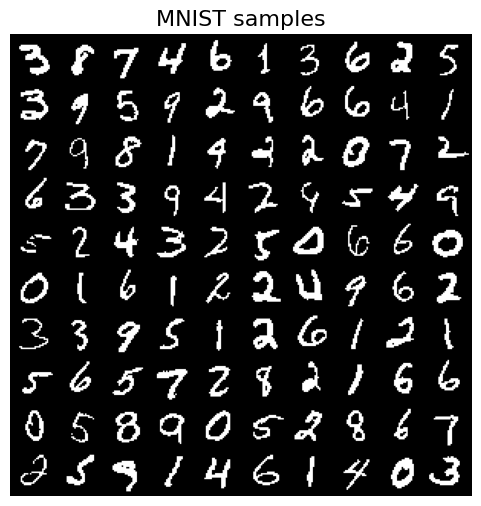

In [5]:
# train_data, test_data = load_pickle('/content/mnist.pkl', flatten=False, binarize=True)
train_data, test_data = load_pickle('mnist.pkl', flatten=False, binarize=True)
visualize_images(train_data, 'MNIST samples')

VQ-VAE model is a VAE model with discrete latent variable.  

**Reminder:**
* We define  dictionary (word book) space $\{\mathbf{e}_k\}_{k=1}^K$, where $\mathbf{e}_k \in \mathbb{R}^C$, $K$ is the size of the dictionary. 
* $\mathbf{z}_e = \text{NN}_e(\mathbf{x}, \boldsymbol{\phi})$ - continuous output of encoder network.
* $\mathbf{z}_q = \mathbf{e}_{k^*}$ is a quantized representation, where $k^* = \text{argmin}_k \| \mathbf{z} - \mathbf{e}_k \|$. It is simple nearest neighbor look up.
* Out deterministic variational posterior:
$$
  q(c = k^* | \mathbf{x}, \boldsymbol{\phi}) = \begin{cases}
  1 , \quad \text{for } k^* = \text{argmin}_k \| \mathbf{z}_e - \mathbf{e}_k \|; \\
  0, \quad \text{otherwise}.
\end{cases}
$$
* Prior distribution is uniform: $p(c) = \text{Uniform}\{1, \dots, K\}$.
* KL divergence between posterior and prior:
$$
  KL(q(c = k^* | \mathbf{x}, \boldsymbol{\phi}), p(c)) = \log K.
$$ 
* ELBO:
$$
		\mathcal{L} (\boldsymbol{\phi}, \boldsymbol{\theta})  = \mathbb{E}_{q(c | \mathbf{x}, \boldsymbol{\phi})} \log p(\mathbf{x} | \mathbf{e}_{c} , \boldsymbol{\theta}) - \log K =  \log p(\mathbf{x} | \mathbf{z}_q, \boldsymbol{\theta}) - \log K.
$$
* Vector quantization is non-differentiable operation. We will use **straight-through** gradient estimator (we will copy gradients from decoder input $\mathbf{z}_q$ to encoder output $\mathbf{z}_e$.

**Important modifications:**
Due to the straight-through gradient estimation of mapping from $\mathbf{z}_e$ to $\mathbf{z}_q$, the embeddings $\mathbf{e} receive no gradients from the ELBO. 

Therefore, in order to learn the embedding space we add l2 loss (**codebook loss**) to move the embedding vectors $\mathbf{e}$ towards the encoder outputs $\mathbf{z}_e$. 

Finally, since the volume of the embedding space is dimensionless, it can grow arbitrarily if the embeddings $\mathbf{e}$ do not train as fast as the encoder parameters. To make sure the encoder commits to an embedding and its output does not grow, we add a **commitment loss**.

Thus, the total training objective becomes:
$$
  \log p(\mathbf{x}| \mathbf{z}_q, \boldsymbol{\theta}) + \| \text{stop_gradient}(\mathbf{z}_e) - \mathbf{e}\|_2^2 + \| \mathbf{z}_e - \text{stop_gradient}(\mathbf{e})\|_2.
$$

Pay attention to the $\text{stop_gradient}(*)$ operator.


Our first step is implement vector quantization procedure. It will also calculate two consistency losses.

In [6]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings=128, embedding_dim=16, beta=0.25):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        self.beta = beta

        # Initialize the embeddings which we will quantize.
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def get_code_indices(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        input_shape = x.shape[:-1]
        flattened = x.view(-1, self.embedding_dim)
        
        # ====
        # 1) calculate distances from flatten inputs to embeddings
        # 2) find nearest embeddings to each input (use argmin op)
        
        # https://github.com/RuHae/TGM_Project/blob/509b670876f8b57d54094ca66db33a3a80effd5c/Code/vq_vae_model.py#L32
        dist = (torch.sum(flattened ** 2, dim=1, keepdim=True)
                     + torch.sum(self.embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flattened, self.embedding.weight.t()))  #
        encoding_indices = torch.argmin(dist, dim=1).unsqueeze(1)  #

        # ====
        encoding_indices = encoding_indices.view(input_shape)
        return encoding_indices

    def get_quantized(self, encoding_indices):
        # ====
        # 1) get embeddgins with appropriate indices
        # 2) transform tensor from BHWC to BCHW format
        
        quantized = self.embedding(encoding_indices)  
        quantized = quantized.permute(0, 3, 1, 2)

        # ====
        return quantized

    def forward(self, x):
        # ====
        # 1) get indices
        # 2) get quantized latents
        # 3) calculate codebook and commitment loss 
        #    do not afraid about stop_gradient op 
        #    (use .detach() method for quantized latents and x)
        # 4) final loss is codebook_loss + beta * commitment_loss
        encoding_indices = self.get_code_indices(x)
        quantized = self.get_quantized(encoding_indices)
        
        commitment_loss = F.mse_loss(quantized.detach(), x)  #
        codebook_loss = F.mse_loss(quantized, x.detach())  #
        loss = codebook_loss + self.beta * commitment_loss
        
        # ====
        
        # Straight-through estimator (think about it!).
        quantized = x + (quantized - x).detach()

        return quantized, loss


def test_vector_quantizer():
    x = torch.zeros((1, 16, 7, 7))
    layer = VectorQuantizer()
    indices = layer.get_code_indices(x)
    assert indices.shape == (1, 7, 7)
    quantized = layer.get_quantized(indices)
    assert quantized.shape == (1, 16, 7, 7)
    quantized, loss = layer(x)
    assert quantized.shape == (1, 16, 7, 7)
    assert loss.shape == ()


test_vector_quantizer()

We will use simple encoder/decoder with several strided convolutions.

In [7]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim, input_size=1):
        super().__init__()
        # ====
        # define Sequential model with Conv2d and ReLU activation
        net = []
        
        net.extend([
                    nn.Conv2d(input_size, latent_dim // 2, kernel_size=2, stride=2),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(latent_dim // 2, latent_dim // 2, kernel_size=2, stride=2),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(latent_dim // 2, latent_dim, kernel_size=1, stride=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(latent_dim, latent_dim, kernel_size=1, stride=1),
        ])
        
        self.net = nn.Sequential(*net)
        
        # ====

    def forward(self, x):
        return self.net(x)


class ConvDecoder(nn.Module):
    def __init__(self, latent_dim, input_size=1):
        super().__init__()
        # ====
        # define Sequential model with ConvTransposed2d and ReLU activation
        net = []
        
        net.extend([
                    nn.ConvTranspose2d(latent_dim, latent_dim, 
                                       kernel_size=2, stride=2), 
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(latent_dim, latent_dim // 2, 
                                       kernel_size=2, stride=2), 
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(latent_dim // 2, latent_dim // 2, 
                                       kernel_size=1, stride=1), 
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(latent_dim // 2, input_size * 2, 
                                       kernel_size=1, stride=1),
                   ])
        
        self.net = nn.Sequential(*net)
        # ====

    def forward(self, z):
        out = self.net(z)
        return out

Now we are ready to define our model. It consists of encoder, decoder and vector quatizer.

In [8]:
class VQVAEModel(nn.Module):
    def __init__(self, ce_loss_scale=1.0, latent_dim=16, num_embeddings=64, latent_size=(7, 7), input_size=1):
        super().__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)
        self.vq_layer = VectorQuantizer(num_embeddings, latent_dim)
        self.ce_loss_scale = ce_loss_scale
        self.latent_size = latent_size
        self.input_size = input_size
        
#     def __init__(self, ce_loss_scale=1.0, latent_dim=16, num_embeddings=64, latent_size=(7, 7)):
#         super().__init__()
#         self.encoder = ConvEncoder(latent_dim)
#         self.decoder = ConvDecoder(latent_dim)
#         self.vq_layer = VectorQuantizer(num_embeddings, latent_dim)
#         self.ce_loss_scale = ce_loss_scale
#         self.latent_size = latent_size

#         self.latent_dim = latent_dim
#         self.num_embeddings = num_embeddings

    def forward(self, x):
        # ====
        # 1) apply encoder
        # 2) apply vector quantizer (it returns quantized representation + vq_loss)
        # 3) apply decoder (it returns decoded samples)
        z = self.encoder(x)
        quantized, vq_loss = self.vq_layer(z) 
        decoded = self.decoder(quantized)
        # ====
        return decoded, vq_loss
        
    def loss(self, x):
        # ====
        # 1) apply model
        # 2) get cross entropy loss 
        decoded, vq_loss = self.forward(x)
        ce_loss = nn.CrossEntropyLoss()(decoded, x.squeeze(1).long())
        # ====
        return {
            "total_loss": self.ce_loss_scale * ce_loss + vq_loss, 
            "ce_loss": self.ce_loss_scale * ce_loss, 
            "vq_loss": vq_loss
        }

    def get_indices(self, x):
        # ====
        # 1) apply encoder
        # 2) get indices of codes using vector quantizer
        z = self.encoder(x)
        codebook_indices = self.vq_layer.get_code_indices(z)
        # ====
        return codebook_indices

    def prior(self, n):
        # ====
        # prior distribution is uniform
        # 1) get samples from categorical distribution
        # 2) get quantized representations using vector quantizer
        z = torch.randint(high=10, size=(n, *self.latent_size)).to(DEVICE).long()  #
        quantized = self.vq_layer.get_quantized(z)  #
        # ====
        return quantized
    
#     def prior(self, n):
#         # ====
#         # your code 
#         # prior distribution is uniform
#         # 1) get samples from categorical distribution
#         # 2) get quantized representations using vector quantizer
#         device = next(self.encoder.parameters()).device
#         codebook_indices = torch.randint(self.num_embeddings, size=(n, *self.latent_size)).to(device)
#         quantized = self.vq_layer.get_quantized(codebook_indices)
#         # ====
#         return quantized

    def sample_from_logits(self, logits):
        # ====
        # our model will return logits, this method applies softmax and samples from the distribution
        # 1) apply softmax to the logits
        # 2) sample from the distribution (e.x. you could use torch.multinomial)
        # be careful with the sizes of the tensors (may be you need to permute/reshape dimensios)
        bs, c, h, w = logits.shape
        l_softmax = logits.softmax(dim=1).permute(0, 2, 3, 1).reshape(-1, self.input_size * 2) # чтобы вероятности оказались в конце
        samples = torch.multinomial(l_softmax, 1).view(bs, self.input_size, h, w)  # можно не переставлять, так как нужная размерность схлопнулась
        
        # ====
        return samples.cpu().numpy()
    
#     def sample_from_logits(self, logits):
#         # ====
#         # your code 
#         # our model will return logits, this method applies softmax and samples from the distribution
#         # 1) apply softmax to the logits
#         # 2) sample from the distribution (e.x. you could use torch.multinomial)
#         # be careful with the sizes of the tensors (may be you need to permute/reshape dimensios)
#         b_size, c, h, w = logits.shape
#         probs = logits.softmax(dim=1).permute(0, 2, 3, 1).reshape(b_size * h * w, logits.shape[1])
#         samples = probs.multinomial(num_samples=1).view(b_size, h, w, 1).permute(0, 3, 1, 2)
#         # ====
#         return samples.cpu().numpy()

    def sample(self, n):
        with torch.no_grad():
            # ====
            # 1) sample from prior distribution
            # 2) apply decoder
            # 3) sample from logits
            z = self.prior(n)
            logits = self.decoder(z)
            samples = self.sample_from_logits(logits)
            # ====
            return samples

def test_vqvae_model():
    model = VQVAEModel(input_size=1).cuda()
    x = torch.zeros((2, 1, 28, 28)).cuda()
    
    encoded = model.encoder(x)
    size = encoded.shape[2:]
    assert size == model.latent_size

    indices = model.get_indices(x)
    assert indices.shape == (2, 7, 7)

    losses = model.loss(x)
    assert isinstance(losses, dict)
    assert 'total_loss' in losses

    quantized = model.prior(10)
    assert quantized.shape == (10, 16, *model.latent_size)

    decoded = model.decoder(quantized)
    assert decoded.shape == (10, 2, 28, 28)

    sampled = model.sample(10)
    assert sampled.shape == (10, 1, 28, 28)


test_vqvae_model()

Let's train our model!

  0%|          | 0/15 [00:00<?, ?it/s]

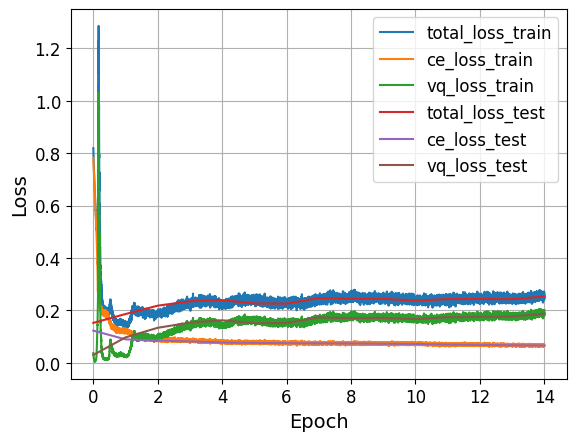

In [10]:
# ====
# choose these parameters
BATCH_SIZE = 64 # any adequate value
EPOCHS = 15     # < 30 
LR = 1e-3         # < 1e-2
CE_SCALE = 1   # 0.01 < x < 30.0
# ====

train_data, test_data = load_pickle('mnist.pkl', flatten=False, binarize=True)

model = VQVAEModel(ce_loss_scale=CE_SCALE, latent_dim=16, num_embeddings=128)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(model, train_loader, test_loader, epochs=EPOCHS, use_cuda=USE_CUDA, 
                                        use_tqdm=True, lr=LR)

plot_training_curves(train_losses, test_losses)

Now we is able to sample from the trained model.

total_loss: 0.2526
ce_loss: 0.0656
vq_loss: 0.1870


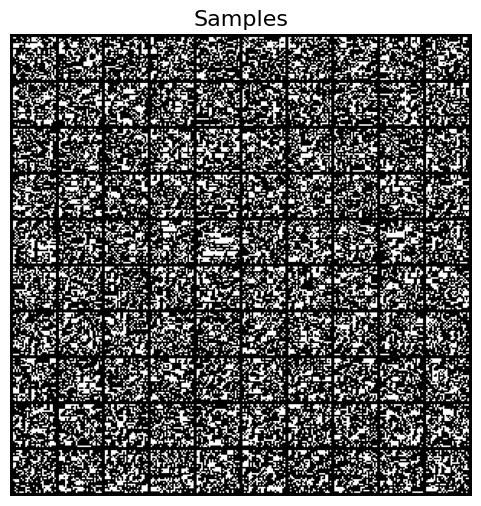

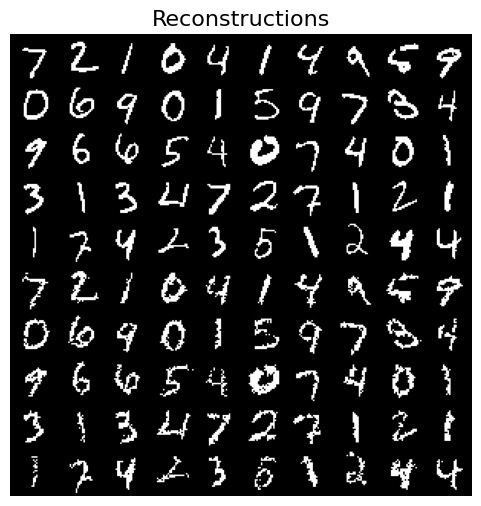

In [11]:
# Test losses
for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))

# Samples
samples = model.sample(100)
samples = samples.astype('float32')
show_samples(samples, title='Samples')

# Reconstructions
x = next(iter(test_loader))[:50].cuda()
with torch.no_grad():
    decoded, _ = model(x)
    x_recon = model.sample_from_logits(decoded)
x = x.cpu().numpy()
reconstructions = np.concatenate((x, x_recon), axis=0)
reconstructions = reconstructions.astype('float32')
show_samples(reconstructions, title='Reconstructions')

Probably you will get bad samples :(

Do not worry, may be it is OK, we will try to fix your samples! Make sure that reconstructions are almost perfect.

Here, we will visualize latent code indices for test images.

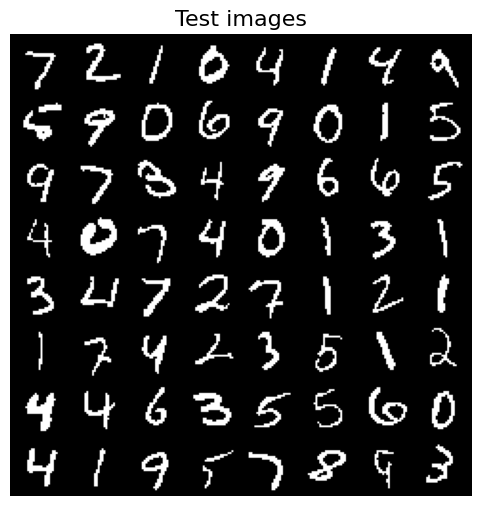

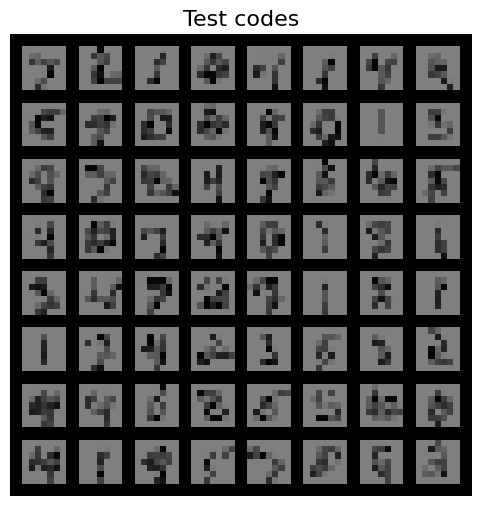

In [12]:
test_images = next(iter(test_loader))[:100]
x = test_images.cuda()
codebook_indices = model.get_indices(x).cpu().unsqueeze(1)

show_samples(test_images, "Test images")
show_samples(codebook_indices, "Test codes")

### Training of prior autoregressive model

The samples from our VQ-VAE model is not good enough. The authors of the original VQ-VAE paper proposed to train autoregressive model in the latent space after we trained VQ-VAE model.

Remember we have discussed **ELBO surgery** and **aggregrated posterior**. Let recall what do we have in VAE:
* **Training:** we get latent variables $\mathbf{z}$ from variational posterior $q(\mathbf{z} | \mathbf{x}, \boldsymbol{\phi})$ for every object $\mathbf{x}$ and then applies decoder ($p(\mathbf{x} | \mathbf{z}, \boldsymbol{\theta})$). It means that in average decoder is applied to the latent variables from aggregated posterior $q_{\text{agg}}(\mathbf{z} | \boldsymbol{\phi})$.
* **Inference:** We apply decoder to the latent variables from prior distribution $p(\mathbf{z})$.

It means that if our aggregated posterior $q_{\text{agg}}(\mathbf{z} | \boldsymbol{\phi})$ and prior $p(\mathbf{z})$ is too far from each other, then we get inconsistency.

So let train to remove this inconsistency. To be concrete, let train (autoregressive) model in the latent space that will try to predict samples from the aggregated posterior $q_{\text{agg}}(\mathbf{z} | \boldsymbol{\phi})$.

We will use our good friend: PixelCNN model.

In [13]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size=5):
        assert mask_type in ['A', 'B']
        super().__init__(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input_):
        # ====
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(input_)
        # ====

    def create_mask(self, mask_type):
        # ====
        # do not forget about mask_type
        # from hw1
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0
        # ====


def test_masked_conv2d():
    layer = MaskedConv2d('A', 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d('B', 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

In [14]:
class PixelCNN(nn.Module):
    def __init__(
        self, 
        num_embeddings=128,
        input_shape=(7, 7), 
        n_filters=32, 
        kernel_size=5, 
        n_layers=5
    ):
      
        super().__init__()
        self.input_shape = input_shape
        self.num_embeddings = num_embeddings

        # ====
        # apply the sequence of MaskedConv2d -> ReLU
        # the last layer should be MaskedConv2d (not ReLU)
        # Note 1: the first conv layer should be of type 'A'
        # Note 2: final output_dim in MaskedConv2d must be 2 (num_embeddings)
        
        net = []
        
        net.extend([
                    MaskedConv2d('A', num_embeddings, n_filters, kernel_size),
                    nn.ReLU(inplace=True)]) # 
        
        for n in range(n_layers - 2):
            net.extend([MaskedConv2d('B', n_filters, n_filters, kernel_size),
                        nn.ReLU(inplace=True)])
        
        net.extend([MaskedConv2d('B', n_filters, num_embeddings, kernel_size),
                    ])

        self.net = nn.Sequential(*net)
        # ====

    def forward(self, x):
        # read the forward method carefully
        flattened = x.view((-1, 1))
        encodings = torch.zeros(flattened.shape[0], self.num_embeddings).cuda()
        encodings.scatter_(1, flattened, 1)
        encodings = encodings.view((-1, *self.input_shape, self.num_embeddings))
        encodings = encodings.permute((0, 3, 1, 2))
        out = self.net(encodings)
        out = out.view(-1, self.num_embeddings, 1, *self.input_shape)
        return out

    def loss(self, x):
        # ====
        total_loss = F.cross_entropy(self(x), x.long())
        # ====
        return {'total_loss': total_loss}

    def sample(self, n):
        # read carefully the sampling process
        samples = torch.zeros(n, 1, *self.input_shape, dtype=torch.int64).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples)[:, :, :, r, c]
                    probs = F.softmax(logits, dim=1).squeeze(-1)
                    samples[:, 0, r, c] = torch.multinomial(probs, num_samples=1).squeeze(-1)
        return samples.cpu().numpy()


def test_pixelcnn():
    model = PixelCNN().cuda()
    x = torch.zeros((1, 1, 7, 7), dtype=torch.int64).cuda()
    output = model(x)
    assert output.shape == (1, 128, 1, 7, 7)
    losses = model.loss(x)
    assert isinstance(losses, dict)
    assert 'total_loss' in losses
    samples = model.sample(10)
    assert samples.shape == (10, 1, 7, 7)


test_pixelcnn()

Now we need to get our train and test samples. Our model will predict indices of the embeddings.

In [15]:
# ====
# you have to get indices of the emdeddings from the VQ-VAE model for train and test data
INPUT_SHAPE = (7, 7) # input shape of your latent space

# модель из предыдущего пункта
train_indices = [model.get_indices(batch.cuda()) for batch in train_loader]
train_indices = torch.cat(train_indices).view(-1, 1, *INPUT_SHAPE).cpu().numpy()

test_indices = [model.get_indices(batch.cuda()) for batch in test_loader]
test_indices = torch.cat(test_indices).view(-1, 1, *INPUT_SHAPE).cpu().numpy()
# ====

assert isinstance(train_indices, np.ndarray)
assert isinstance(test_indices, np.ndarray)
assert train_indices.shape == (60000, 1, *INPUT_SHAPE)
assert test_indices.shape == (10000, 1, *INPUT_SHAPE)

In [16]:
# ====
# choose these parameters by your own
EPOCHS = 25      # > 5
BATCH_SIZE = 64  # any adequate value
LR = 3e-4          # < 1e-2
N_LAYERS = 6    # < 10
N_FILTERS = 64   # < 128
# ====

prior_model = PixelCNN(
    input_shape=INPUT_SHAPE, 
    n_filters=N_FILTERS, 
    kernel_size=5, 
    n_layers=N_LAYERS
)

train_loader = data.DataLoader(train_indices, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_indices, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(
    prior_model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA
)

  0%|          | 0/25 [00:00<?, ?it/s]

Now we are ready to sample from our VQ-VAE model. The difference here that we will sample our embedding indices from the PixelCNN prior model instead of the Uniform prior distribution.

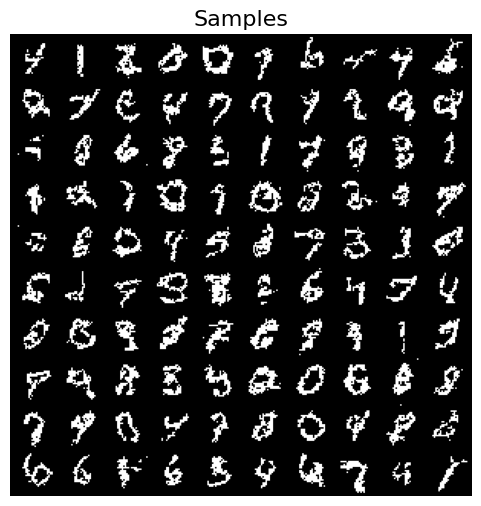

In [17]:
N_SAMPLES = 100
indices = prior_model.sample(N_SAMPLES).squeeze(1)
quantized = model.vq_layer.get_quantized(torch.Tensor(indices).int().cuda())
logits = model.decoder(quantized)
samples = model.sample_from_logits(logits)

samples = samples.astype('float32')
show_samples(samples, title='Samples')

Here you have to get samples with good enough (better than before) quality!